# Hands-on Day 2

- course [slides](https://github.com/Course-bigDataAndML/MLCourse-INFN-2022/blob/master/Slides/Day2/Big%20data%20science%20-%20Day%202%20-%20INFN%202022.pdf)


## You'll learn

### ML methods

- Multilayer Perceptron Classifier (MCP) with pyspark.ml

### ML techniques

- hyperparameter optimisation
- ROC curves

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# our custom functions
from custom_functions import *

#### Remember to start spark by clicking on the square icon all the way to the right

Setup and restart the Spark context with our configuration

In [2]:
from pyspark.sql import SparkSession
from pyspark import SparkConf, SparkContext

# get token to authenticate to minio storage
!eval `oidc-keychain` > /dev/null && oidc-token dodas --time=3600 > /tmp/token
with open('/tmp/token') as f:
    token = f.readlines()[0].split("\n")[0]

# build Spark configuration options    
conf = setupSpark(token)

# to update Spark config, we need first to stop the spark context
SparkContext.stop(sc)

# Then create first spark context, and then session
sc = SparkContext(conf = conf)
spark = SparkSession.builder.config(conf=conf).getOrCreate()

# check if Spark is there
sc

<SparkContext master=k8s://https://kubernetes:443 appName=MyApp>

# Data preprocessing

In [3]:
inputFile = "s3a://scratch/legger/higgs/Higgs100k.parquet"

%time df = spark.read.format('parquet').option('header', 'true').option('inferschema', 'true').load(inputFile)

total_events = df.count()
print('There are '+str(total_events)+' events')

CPU times: user 6.28 ms, sys: 3.32 ms, total: 9.6 ms
Wall time: 6.58 s
There are 99999 events


In [4]:
#split the dataset for training and test
train, test = df.randomSplit([0.8,0.2])

print('Events for training {}'.format(train.count()))
print('Events for validation {}'.format(test.count()))

Events for training 79964
Events for validation 20035


In [6]:
# create the input feature vector 
feature = train.columns
feature.remove('label')

from pyspark.ml.feature import VectorAssembler
print(feature)
print(str(len(feature)))

#VectorAssembler is a transformer that combines a given list of columns into a single vector column
assembler = VectorAssembler(inputCols=feature, outputCol='features')
train = assembler.transform(train)
test = assembler.transform(test)

['lepton_pT', 'lepton_eta', 'lepton_phi', 'missing_energy_magnitude', 'missing_energy_phi', 'jet1_pt', 'jet1_eta', 'jet1_phi', 'jet1_b-tag', 'jet2_pt', 'jet2_eta', 'jet2_phi', 'jet2_b-tag', 'jet3_pt', 'jet3_eta', 'jet3_phi', 'jet3_b-tag', 'jet4_pt', 'je4_eta', 'jet4_phi', 'jet4_b-tag', 'm_jj', 'm_jjj', 'm_lv', 'm_jlv', 'm_bb', 'm_wbb', 'm_wwbb']
28


# Exercise 1

- Implement a shallow NN: use *MultiLayerPerceptronClassifier* from pyspark
- documentation: https://spark.apache.org/docs/latest/ml-classification-regression.html#multilayer-perceptron-classifier
- implement a network with: 
  - one input layer of size 28 (our features), 
  - two intermediate layers of size 30,
  - one output of size 2 (the label classes)
  - other hyerparameters: maxIter=100, blockSize=128, seed=1234
- plot the various metrics (ROC, signal vs background)
- bonus: do hyperparameter optimisation

In [7]:
from pyspark.ml.classification import MultilayerPerceptronClassifier

# Your code here
mpc = MultilayerPerceptronClassifier(layers =[28,30,30,2], maxIter=100, blockSize=128, seed=1234)

In [8]:
%%time
model_mpc = mpc.fit(train)

CPU times: user 742 ms, sys: 163 ms, total: 905 ms
Wall time: 1min 46s


In [9]:
# compute accuracy on the test set
from pyspark.ml.evaluation import BinaryClassificationEvaluator

#Your code here
result = model_mpc.transform(test)

from pyspark.ml.evaluation import BinaryClassificationEvaluator
evaluator = BinaryClassificationEvaluator(labelCol='label', metricName="areaUnderROC")
print("Test set AUC = " + str(evaluator.evaluate(result)))

printMetrics(evaluator,result)

Test set AUC = 0.7329282217415605
AUC: 0.733
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0| 7913|
|  0.0|       1.0| 3783|
|  1.0|       0.0| 2723|
|  0.0|       0.0| 5616|
+-----+----------+-----+

n precision: 0.677
n recall: 0.744
n accuracy: 0.675
n F1 score: 0.709


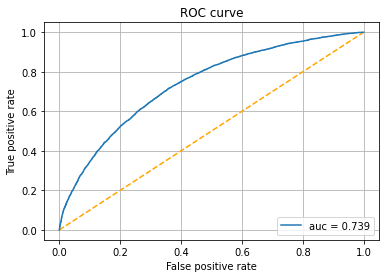

In [10]:
#make ROC curve

# Your code here
model_mpc.extractParamMap()

drawROC(result)

In [ ]:
#plot signal vs background with prediction

# Your code here
plotSignalvsBgWithPrediction(test, result, 'm_bb')